In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.utils import shuffle
import tqdm
import random

### Preprocessing data

In [2]:
from common import get_data, get_freq_data, signal_cyclic_shift, generate_multi_signal

In [3]:
X_origin, y_origin = get_data(data_path='./data/na62_11_pulses.txt')

In [4]:
def prepare_data(X_origin, y_origin, alpha_range, data_size=1000, to_print=False):
    pos_size = int(data_size/2)
    neg_size = data_size - pos_size
    
    X = []
    y = []
    for i in range(data_size):
        alpha = random.choice(alpha_range)
        
        if i < pos_size:
            X.append(random.choice(X_origin))
#             X.append(generate_multi_signal(X_origin, y_origin, tau, alpha)['first_impulse'])

            y.append(1)
        else:
            X.append(generate_multi_signal(X_origin, y_origin, alpha)['multi_impulse'])
            y.append(0)
   
    X = np.array(X)
    y = np.array(y)
   
    if to_print:
#         print("X positive shape:", X_positive.shape)
#         print("y positive shape:", y_positive.shape)
#         print("X negative shape:", X_negative.shape)
#         print("y negative shape:", y_negative.shape)
        print("X shape:", X.shape)
        print("y shape:", y.shape)
    
    X, y = shuffle(X, y)

    return X, y

In [5]:
alpha_range = np.array([np.around(10**i, decimals=4) for i in np.arange(-3, 3.1, 0.1)])
# tau_range = np.arange(-25, 25, 1)
X, y = prepare_data(X_origin, y_origin, alpha_range, data_size=5000, to_print=True)

X shape: (5000, 1024)
y shape: (5000,)


In [6]:
len(X)

5000

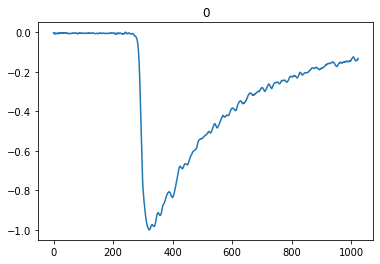

In [7]:
import random
i = random.choice(range(len(X)))
plt.title(str(y[i]))
plt.plot(X[i])
plt.show()

### Models

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier

In [9]:
freq_values = [1, 5, 10, 15, 25, 50, 60, 75, 85, 100]

In [10]:
def print_results(iter_num=200):
    global X_freq
    for freq in freq_values:
        X_freq = get_freq_data(X, freq=freq)

        best = fmin(
            fn=f,  # "Loss" function to minimize
            space=space,  # Hyperparameter space
            algo=tpe.suggest,  # Tree-structured Parzen Estimator (TPE)
            max_evals=iter_num  # Perform 100 trials
        )

        print('-----------------------------------------------------')
        print("Freq:", freq)
        print("X_freq shape:", X_freq.shape)
        print("Found minimum after %d trials:" %(iter_num))
        print(best)
        print('-----------------------------------------------------')

### Hyperopt

In [11]:
from hyperopt.pyll import scope as ho_scope
from hyperopt import fmin, tpe, hp

###### KNeighborsClassifier

In [12]:
def f(space):
        model = KNeighborsClassifier(n_neighbors=space['n_neighbors'], weights=space['weights'],\
                                     algorithm=space['algorithm'], leaf_size=space['leaf_size'], p=space['p'])
        scores = cross_validate(model, X_freq, y, scoring='accuracy', cv=5)
        return -scores['test_score'].mean()

space = {
        'n_neighbors': ho_scope.int(hp.quniform('n_neighbors', low=2, high=10, q=1)),
        'weights':  hp.choice('weights', ['uniform', 'distance']),
        'algorithm': hp.choice('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
        'leaf_size': ho_scope.int(hp.quniform('leaf_size', low=4, high=60, q=2)),
        'p': hp.choice('p', [1, 2])
}
    
global X_freq
print_results(iter_num=50)

100%|██████████| 50/50 [09:51<00:00, 11.82s/it, best loss: -0.6958]
-----------------------------------------------------
Freq: 1
X_freq shape: (5000, 1024)
Found minimum after 50 trials:
{'algorithm': 1, 'leaf_size': 4.0, 'n_neighbors': 2.0, 'p': 0, 'weights': 1}
-----------------------------------------------------
100%|██████████| 50/50 [01:19<00:00,  1.59s/it, best loss: -0.7001999999999999]
-----------------------------------------------------
Freq: 5
X_freq shape: (5000, 205)
Found minimum after 50 trials:
{'algorithm': 0, 'leaf_size': 46.0, 'n_neighbors': 2.0, 'p': 1, 'weights': 1}
-----------------------------------------------------
100%|██████████| 50/50 [00:57<00:00,  1.15s/it, best loss: -0.6975999999999999]
-----------------------------------------------------
Freq: 10
X_freq shape: (5000, 103)
Found minimum after 50 trials:
{'algorithm': 2, 'leaf_size': 16.0, 'n_neighbors': 2.0, 'p': 0, 'weights': 1}
-----------------------------------------------------
100%|██████████| 5

##### DecisionTreeClassifier

In [13]:
def f(space):
    model = DecisionTreeClassifier(max_depth=space['max_depth'], max_features=space['max_features'],\
                                  criterion=space['criterion'], min_samples_split=space['min_samples_split'],\
                                  min_samples_leaf=space['min_samples_leaf'], min_weight_fraction_leaf = space['min_weight_fraction_leaf'])
    scores = cross_validate(model, X_freq, y, scoring='accuracy', cv=5)
    return -scores['test_score'].mean()
    
space = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'min_samples_split': ho_scope.int(hp.quniform('min_samples_split', low=2, high=10, q=1)),
    'min_samples_leaf':  ho_scope.int(hp.quniform('min_samples_leaf', low=1, high=10, q=1)),
    'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0, 0.5),
}

global X_freq
print_results()

100%|██████████| 200/200 [01:16<00:00,  2.63it/s, best loss: -0.6450000000000001]
-----------------------------------------------------
Freq: 1
X_freq shape: (5000, 1024)
Found minimum after 200 trials:
{'criterion': 0, 'max_depth': 15, 'max_features': 0, 'min_samples_leaf': 5.0, 'min_samples_split': 2.0, 'min_weight_fraction_leaf': 0.00045911552145954185}
-----------------------------------------------------
100%|██████████| 200/200 [00:37<00:00,  5.37it/s, best loss: -0.6597999999999999]
-----------------------------------------------------
Freq: 5
X_freq shape: (5000, 205)
Found minimum after 200 trials:
{'criterion': 1, 'max_depth': 17, 'max_features': 1, 'min_samples_leaf': 2.0, 'min_samples_split': 4.0, 'min_weight_fraction_leaf': 5.454801579346524e-06}
-----------------------------------------------------
100%|██████████| 200/200 [00:23<00:00,  8.41it/s, best loss: -0.6512]            
-----------------------------------------------------
Freq: 10
X_freq shape: (5000, 103)
Found

##### RandomForest

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
def f(space):
    model = RandomForestClassifier(max_depth=space['max_depth'], max_features=space['max_features'],\
                                  criterion=space['criterion'], min_samples_split=space['min_samples_split'],\
                                  min_samples_leaf=space['min_samples_leaf'], min_weight_fraction_leaf = space['min_weight_fraction_leaf'],\
                                  verbose=0)
    scores = cross_validate(model, X_freq, y, scoring='accuracy', cv=5)
    return -scores['test_score'].mean()
    
space = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'min_samples_split': ho_scope.int(hp.quniform('min_samples_split', low=2, high=10, q=1)),
    'min_samples_leaf':  ho_scope.int(hp.quniform('min_samples_leaf', low=1, high=10, q=1)),
    'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0, 0.5),
}

global X_freq
print_results()

100%|██████████| 200/200 [07:07<00:00,  2.14s/it, best loss: -0.6722]
-----------------------------------------------------
Freq: 1
X_freq shape: (5000, 1024)
Found minimum after 200 trials:
{'criterion': 1, 'max_depth': 12, 'max_features': 0, 'min_samples_leaf': 1.0, 'min_samples_split': 4.0, 'min_weight_fraction_leaf': 0.000513048398091933}
-----------------------------------------------------
100%|██████████| 200/200 [03:40<00:00,  1.10s/it, best loss: -0.6432]
-----------------------------------------------------
Freq: 5
X_freq shape: (5000, 205)
Found minimum after 200 trials:
{'criterion': 1, 'max_depth': 15, 'max_features': 0, 'min_samples_leaf': 10.0, 'min_samples_split': 6.0, 'min_weight_fraction_leaf': 0.0034239897961710008}
-----------------------------------------------------
100%|██████████| 200/200 [02:49<00:00,  1.18it/s, best loss: -0.6442]           
-----------------------------------------------------
Freq: 10
X_freq shape: (5000, 103)
Found minimum after 200 trials:

##### GaussianNB

In [16]:
def f(space):
    model = GaussianNB(var_smoothing=space['var_smoothing'])
    scores = cross_validate(model, X_freq, y, scoring='accuracy', cv=5)
    return -scores['test_score'].mean()
    
space = {
    'var_smoothing': hp.loguniform('var_smoothing', low=np.log(1e-10), high=np.log(1e-7))
}

global X_freq
print_results()

100%|██████████| 200/200 [01:52<00:00,  1.78it/s, best loss: -0.5418000000000001]
-----------------------------------------------------
Freq: 1
X_freq shape: (5000, 1024)
Found minimum after 200 trials:
{'var_smoothing': 4.8338942708731355e-08}
-----------------------------------------------------
100%|██████████| 200/200 [00:16<00:00, 12.09it/s, best loss: -0.5384]
-----------------------------------------------------
Freq: 5
X_freq shape: (5000, 205)
Found minimum after 200 trials:
{'var_smoothing': 5.736813402126445e-08}
-----------------------------------------------------
100%|██████████| 200/200 [00:09<00:00, 21.82it/s, best loss: -0.5406000000000001]
-----------------------------------------------------
Freq: 10
X_freq shape: (5000, 103)
Found minimum after 200 trials:
{'var_smoothing': 1.4250274367036234e-09}
-----------------------------------------------------
100%|██████████| 200/200 [00:07<00:00, 27.53it/s, best loss: -0.542]
------------------------------------------------

##### SVC

In [ ]:
def f(space):
    model = SVC(C=space['C'], kernel=space['kernel'], degree=space['degree'], gamma=space['gamma'],\
               shrinking=space['shrinking'])
    scores = cross_validate(model, X_freq, y, scoring='accuracy', cv=5)
    return -scores['test_score'].mean()
    
space = {
    'C': hp.loguniform('C', low=np.log(0.01), high=np.log(1)),
    'kernel': hp.choice('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
    'degree':  ho_scope.int(hp.quniform('degree', low=2, high=5, q=1)),
    'gamma':  hp.loguniform('gamma', low=np.log(0.001), high=np.log(100)),
    'shrinking': hp.choice('shrinking', [True, False])
}

global X_freq
print_results(iter_num=50)

 62%|██████▏   | 31/50 [2:20:06<2:50:48, 539.42s/it, best loss: -0.6972]         

##### PassiveAggressiveClassifier

In [13]:
def f(space):
    model = PassiveAggressiveClassifier(C=space['C'], fit_intercept=space['fit_intercept'])
    scores = cross_validate(model, X_freq, y, scoring='accuracy', cv=5)
    return -scores['test_score'].mean()
    
space = {
    'C': hp.loguniform('C', low=np.log(0.01), high=np.log(1)),
    'fit_intercept': hp.choice('fit_intercept', [True, False]),
}

global X_freq
print_results()

100%|██████████| 200/200 [02:20<00:00,  1.42it/s, best loss: -0.504]             
-----------------------------------------------------
Freq: 1
X_freq shape: (5000, 1024)
Found minimum after 200 trials:
{'C': 0.04927225867676801, 'fit_intercept': 0}
-----------------------------------------------------
100%|██████████| 200/200 [00:32<00:00,  6.24it/s, best loss: -0.5130000000000001]
-----------------------------------------------------
Freq: 5
X_freq shape: (5000, 205)
Found minimum after 200 trials:
{'C': 0.019999891521113793, 'fit_intercept': 1}
-----------------------------------------------------
100%|██████████| 200/200 [00:19<00:00, 10.26it/s, best loss: -0.5182]           
-----------------------------------------------------
Freq: 10
X_freq shape: (5000, 103)
Found minimum after 200 trials:
{'C': 0.045743072376309535, 'fit_intercept': 0}
-----------------------------------------------------
100%|██████████| 200/200 [00:15<00:00, 13.20it/s, best loss: -0.5274]
------------------

#####  MLPClassifier

In [12]:
def f(space):
    model = MLPClassifier(hidden_layer_sizes=(space['first_size'], space['second_size']), 
                          activation=space['activation'], batch_size=16,
                         max_iter=space['max_iter'], learning_rate=space['learning_rate'],\
                         learning_rate_init=space['learning_rate_init'])
    scores = cross_validate(model, X_freq, y, scoring='accuracy', cv=5)
    return -scores['test_score'].mean()
    
space = {
    'first_size':  ho_scope.int(hp.quniform('first_size', low=50, high=100, q=10)),
    'second_size':  ho_scope.int(hp.quniform('second_size', low=10, high=40, q=5)),
    'activation': hp.choice('activation', ['identity', 'logistic', 'tanh', 'relu']),
    'learning_rate': hp.choice('learning_rate', ['constant', 'invscaling', 'adaptive']),
    'learning_rate_init': hp.loguniform('learning_rate_init', low=np.log(0.00001), high=np.log(0.1)),
    'max_iter': ho_scope.int(hp.quniform('max_iter', low=300, high=500, q=25))
}

global X_freq
print_results(iter_num=5)

100%|██████████| 5/5 [09:40<00:00, 116.03s/it, best loss: -0.5022]
-----------------------------------------------------
Freq: 1
X_freq shape: (5000, 1024)
Found minimum after 5 trials:
{'activation': 2, 'first_size': 80.0, 'learning_rate': 1, 'learning_rate_init': 0.0012757746198528675, 'max_iter': 450.0, 'second_size': 20.0}
-----------------------------------------------------
100%|██████████| 5/5 [04:32<00:00, 54.47s/it, best loss: -0.5296000000000001]
-----------------------------------------------------
Freq: 5
X_freq shape: (5000, 205)
Found minimum after 5 trials:
{'activation': 1, 'first_size': 80.0, 'learning_rate': 1, 'learning_rate_init': 0.0010713389885314152, 'max_iter': 425.0, 'second_size': 15.0}
-----------------------------------------------------
100%|██████████| 5/5 [13:40<00:00, 164.12s/it, best loss: -0.6326]
-----------------------------------------------------
Freq: 10
X_freq shape: (5000, 103)
Found minimum after 5 trials:
{'activation': 3, 'first_size': 80.0, 